In [ ]:
import sys
!{sys.executable} -m pip install pymoo  # For ipopt solver

# Install a pip package in the current Jupyter kernel

from IPython.display import display_html
def restartkernel() :
    display_html("<script>Jupyter.notebook.kernel.restart()</script>",raw=True)

restartkernel()

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 7.1 MB/s eta 0:00:00m eta 0:00:010:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.9/75.9 KB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 KB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49.3 KB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 249.1/249.1 KB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.9/840.9 KB 11.2 MB/s eta 0:00:00m eta 0:00:010:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 KB 11.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for grapheme: filename=grapheme-0.6.0-py3-none-any.whl size=210079 sha256=b837268cf6014336c8f06e7994b044f6ca39165732e0a19b0836b3345b447f9b
  Stored in directory: /headless/.cache/pip/wheels/01/e1/49/37e6bde9886439057450c494a7

In [1]:
import os
from spyci import spyci
import matplotlib.pyplot as plt
%matplotlib inline

# Write a file 4th_order_rc_test.spice

In [97]:
%%writefile inv.spice
********Digital inverter**********
.PARAM WP = 1.5e-6
.PARAM LMIN = 0.39e-6
**--**--**--**--**--**--**--**--**--**

*** *** SUPPLY VOLTAGES *** ***
VDD VDD 0 3.3
VSS VSS 0 0
VIN IN  0 1

*** *** CIRCUIT *** ***
MP OUT IN VDD VDD PM W={WP}    L={LMIN} pd={2*WP}   ps={2*WP}
MN OUT IN VSS VSS NM W={WP/3}  L={LMIN} pd={2/3*WP} ps={2/3*WP}
CL OUT VSS 12p

*** *** ANALYSIS *** ***

.options savecurrents
.include b3.typ

.control
set color0 =white
set filetype = ascii
dc VIN 0 3.3 0.01
*plot OUT @mn[id]*20000

meas dc switch_point find out WHEN v-sweep=1.65 CROSS=LAST
meas dc i_max    MAX    @mn[id] 
meas dc i_max_at MAX_AT @mn[id]

print switch_point i_max i_max_at

write inv.raw OUT @mn[id] switch_point i_max i_max_at
.endc

.END

Overwriting inv.spice


In [98]:
filename="inv.raw"
data = spyci.load_raw(filename)  # see 'Data structure' section below
spyci.list_vars(filename)

Variables:

  idx  name          type
-----  ------------  -------------
    1  v(out)        voltage
    2  i(@mn[id])    current
    3  switch_point  notype dims=1
    4  i_max         notype dims=1
    5  i_max_at      notype dims=1


In [99]:
def add_param_lines(file_path, param_names_and_values):
    
  if not os.path.exists(file_path):
    raise FileNotFoundError("File does not exist: {}".format(file_path))

  with open(file_path, "r") as f:
    lines = f.readlines()

  first_line = lines[0]

  param_lines = []
  for param_name, param_value in param_names_and_values:
    param_lines.append(".PARAM {} = {}\n".format(param_name, param_value))

  # Find the index of the line with the text `"**--**--**--**--**--**--**--**--**--**\n`
  recognizer="**--**--**--**--**--**--**--**--**--**\n"
  try:
      index = lines.index(recognizer)
      new_lines = [first_line] + param_lines + [recognizer] + lines[index + 1:]
  except ValueError:
      new_lines = [first_line] + param_lines + [recognizer] + lines[1:]

  with open(file_path, "w") as f:
    f.writelines(new_lines)


In [100]:
def get_values(filename, pvars=None):
    """
    Load the values from a SPICE raw file and return a list of arrays.

    Args:
        filename (str): The path to the SPICE raw file.
        pvars (list): A list of string variables to load. If None, all variables are loaded.

    Returns:
        list: A list of arrays, one for each variable in pvars.
    """

    d = spyci.load_raw(filename)
    xx = []
    for var in pvars:
        xx.append(d['values'][var].real)
    return xx

# Test the add_param_function

In [101]:
filename = "inv.spice"
param_names_and_values = [
    
    ["WP",   1.8e-6], 
    ["LMIN", 0.39e-6]

    ]
add_param_lines(filename, param_names_and_values)

# View the contents

In [102]:
r=os.system("cat inv.spice")

********Digital inverter**********
.PARAM WP = 1.8e-06
.PARAM LMIN = 3.9e-07
**--**--**--**--**--**--**--**--**--**

*** *** SUPPLY VOLTAGES *** ***
VDD VDD 0 3.3
VSS VSS 0 0
VIN IN  0 1

*** *** CIRCUIT *** ***
MP OUT IN VDD VDD PM W={WP}    L={LMIN} pd={2*WP}   ps={2*WP}
MN OUT IN VSS VSS NM W={WP/3}  L={LMIN} pd={2/3*WP} ps={2/3*WP}
CL OUT VSS 12p

*** *** ANALYSIS *** ***

.options savecurrents
.include b3.typ

.control
set color0 =white
set filetype = ascii
dc VIN 0 3.3 0.01
*plot OUT @mn[id]*20000

meas dc switch_point find out WHEN v-sweep=1.65 CROSS=LAST
meas dc i_max    MAX    @mn[id] 
meas dc i_max_at MAX_AT @mn[id]

print switch_point i_max i_max_at

write inv.raw OUT @mn[id] switch_point i_max i_max_at
.endc

.END


# Test the get_values function

In [103]:
get_values("inv.raw",['switch_point'])


[array([0.4504625, 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.      

In [106]:
import os
def run_spice_again(x,param_names,filename,var_to_output):
#     param_names_and_values = [  
#         ["WP",   x[0]], 
#         ["LMIN", x[1]], 
#         ["VD",  3.3]
#         ]
    param_names_and_values = [[param_name, value] for param_name, value in zip(param_names, x)]
    add_param_lines(filename, param_names_and_values)
    
    os.system("ngspice -b inv.spice -o .log > .log")
#     os.system("rm -f .temp")
    filename="inv.raw"
    data = spyci.load_raw(filename)  # see 'Data structure' section below
    output=get_values(filename,[var_to_output])[0][0]
#     print(switch_point)
    return output

print(run_spice_again([1.5e-6,0.35e-6],["WP","LMIN"],"inv.spice",'i_max'))

8.609826999999999e-05


In [166]:
from pymoo.util.display.column import Column
from pymoo.util.display.output import Output


class MyOutput(Output):

    def __init__(self,variables):
        super().__init__()

        # Define your variable names here as a list of strings
        self.variable_names = ["n_Gen"]
        self.variable_names+= variables

        # Create columns for each variable with specified widths
        self.columns = [Column(var_name, width=10) for var_name in self.variable_names]

    def update(self, algorithm):
        super().update(algorithm)

        # Get the variable values from the algorithm's population
        x_values = algorithm.pop.get("X")

        # Update the columns with the respective variable values
        for i, var_name in enumerate(self.variable_names):
            if i==0:
                self.columns[0].set(algorithm.n_gen)
            else:
                self.columns[i].set(x_values[0][i-1])
#         print(dir(algorithm))


In [209]:
import numpy as np
from pymoo.problems.functional import FunctionalProblem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM
from pymoo.operators.sampling.rnd import FloatRandomSampling
from pymoo.termination import get_termination
from pymoo.optimize import minimize
from datetime import datetime
import random

def find_values(n_var,variable_names,x,range_l,range_u,objs,max_generations,verbose=True,randomize_seed=False):

  # now put everything together to a problem object
  problem = FunctionalProblem(n_var,
                              objs,
                              # constr_ieq=constr_ieq,
                              xl=np.array(range_l),
                              xu=np.array(range_u)
                              )
    
#   F= problem.evaluate([x])
  
  ###########
  algorithm = NSGA2(
    pop_size=45,
    n_offsprings=10,
    sampling=FloatRandomSampling(),
    crossover=SBX(prob=0.9, eta=15),
    mutation=PM(eta=15),
    eliminate_duplicates=True
  )
  ##############
  termination = get_termination("n_gen", max_generations)
  ##############
  if randomize_seed:
        random.seed(datetime.now().timestamp())
        seed=random.randint(0, 50)
  else:
        seed=5
        
  res = minimize(problem,
               algorithm,
               termination,
               seed=seed,
               output=MyOutput(variable_names),
               save_history=True,
               verbose=verbose)
  
  return res



In [216]:
#########################
range_l=[0.5e-6, 0.15e-6]
range_u=[8e-6, 4e-6]
target_switch_point=1.65
target_i_max_at=1.65
x=[]
max_generations=40
verbose=True
randomize_seed=False
variable_names=["WP", "LMIN"]

current_x=[1.8e-6,0.35e-6]
# print(run_spice_again(current_x,variable_names,'inv.spice','switch_point'))
#########################COST_FUNCTION##########################################
cost_function = [
    lambda x: (run_spice_again(x,variable_names,"inv.spice",'switch_point')-target_switch_point)**2, ####for the switchpoint of the inverter
    lambda x: (run_spice_again(x,variable_names,"inv.spice",'i_max_at')-target_i_max_at)**2 ####for the switchpoint of the inverter
]
################################################################################

r=find_values(2,variable_names,x,range_l,range_u,cost_function,max_generations,verbose=verbose,randomize_seed=randomize_seed)

result=r.X.T


  n_Gen    |     WP     |    LMIN   
         1 |  6.686E-06 |  5.127E-07
         2 |  6.686E-06 |  5.127E-07
         3 |  6.686E-06 |  5.127E-07
         4 |  7.038E-06 |  3.616E-07
         5 |  7.038E-06 |  3.616E-07
         6 |  7.038E-06 |  3.616E-07
         7 |  3.914E-06 |  5.127E-07
         8 |  3.914E-06 |  5.127E-07
         9 |  3.914E-06 |  5.127E-07
        10 |  4.716E-06 |  4.587E-07
        11 |  4.716E-06 |  4.587E-07
        12 |  4.716E-06 |  4.587E-07
        13 |  4.716E-06 |  4.587E-07
        14 |  4.716E-06 |  4.587E-07
        15 |  4.716E-06 |  4.587E-07
        16 |  2.115E-06 |  4.730E-07
        17 |  2.115E-06 |  4.730E-07
        18 |  2.115E-06 |  4.730E-07
        19 |  2.115E-06 |  4.730E-07
        20 |  1.995E-06 |  4.088E-07
        21 |  1.995E-06 |  4.088E-07
        22 |  1.995E-06 |  4.088E-07
        23 |  1.995E-06 |  4.088E-07
        24 |  2.203E-06 |  4.143E-07
        25 |  3.208E-06 |  4.858E-07
        26 |  3.208E-06 |  4.858E-07
 

In [217]:
errors=[]
for index in range(len(result[0])):
    WP_opt=result[0][index]  #1kOhm
    LMIN_opt=result[1][index]  # 1µF

    obtained_switch_point=run_spice_again([WP_opt,LMIN_opt],variable_names,"inv.spice",'switch_point')
    obtained_imax_point=run_spice_again([WP_opt,LMIN_opt],variable_names,"inv.spice",'i_max_at')
    error=(((0.5*(obtained_switch_point+obtained_imax_point))-target_switch_point)*100/target_switch_point)
    errors.append(abs(error))
    print("========================================")
    print("Percentage Error is: {:7.4f} %".format(error))
    print("Target switch_point: {:7.3f} V".format(target_switch_point))
    print("Obtained switch_point(Optimized value ) is: {:7.3f} V".format(obtained_switch_point))
    print("Obtained imax_point(Optimized value ) is: {:7.3f} V".format(obtained_imax_point))    
    print("Width WP(Optimized value ) is: {:7.3f} um".format(WP_opt*1e6))
    print("Length LMIN(Optimized value ) is: {:7.3f} um".format(LMIN_opt*1e6))
    print("========================================")
    print()
best_case_index=errors.index(min(errors))
WP_opt=result[0][best_case_index]  #1kOhm
LMIN_opt=result[1][best_case_index]  # 1µF
obtained_switch_point=run_spice_again([WP_opt,LMIN_opt],variable_names,"inv.spice",'switch_point')

Percentage Error is: -7.8813 %
Target switch_point:   1.650 V
Obtained switch_point(Optimized value ) is:   1.390 V
Obtained imax_point(Optimized value ) is:   1.650 V
Width WP(Optimized value ) is:   2.357 um
Length LMIN(Optimized value ) is:   0.459 um

Percentage Error is: -0.0772 %
Target switch_point:   1.650 V
Obtained switch_point(Optimized value ) is:   1.637 V
Obtained imax_point(Optimized value ) is:   1.660 V
Width WP(Optimized value ) is:   3.913 um
Length LMIN(Optimized value ) is:   0.453 um



# See the Optimized Values after best case selection

In [218]:
r=os.system("cat inv.spice")

********Digital inverter**********
.PARAM WP = 3.912908005215549e-06
.PARAM LMIN = 4.528549498340625e-07
**--**--**--**--**--**--**--**--**--**

*** *** SUPPLY VOLTAGES *** ***
VDD VDD 0 3.3
VSS VSS 0 0
VIN IN  0 1

*** *** CIRCUIT *** ***
MP OUT IN VDD VDD PM W={WP}    L={LMIN} pd={2*WP}   ps={2*WP}
MN OUT IN VSS VSS NM W={WP/3}  L={LMIN} pd={2/3*WP} ps={2/3*WP}
CL OUT VSS 12p

*** *** ANALYSIS *** ***

.options savecurrents
.include b3.typ

.control
set color0 =white
set filetype = ascii
dc VIN 0 3.3 0.01
*plot OUT @mn[id]*20000

meas dc switch_point find out WHEN v-sweep=1.65 CROSS=LAST
meas dc i_max    MAX    @mn[id] 
meas dc i_max_at MAX_AT @mn[id]

print switch_point i_max i_max_at

write inv.raw OUT @mn[id] switch_point i_max i_max_at
.endc

.END


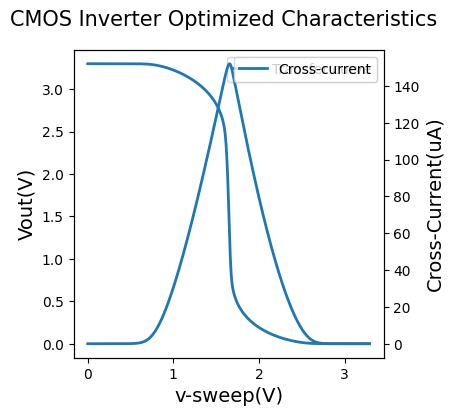

In [219]:
values=get_values("inv.raw",['i(@mn[id])','v(out)','switch_point','i_max','i_max_at'])
v_sweep=np.arange(0, 3.3, 3.3/len(values[1]))

fig, ax1 = plt.subplots(figsize=(4, 4))
ax2 = ax1.twinx()
fig.suptitle("CMOS Inverter Optimized Characteristics", fontsize=15)
ax1.set_xlabel("v-sweep(V)", fontsize=14)
ax2.set_ylabel("Cross-Current(uA)", fontsize=14)

ax1.set_ylabel("Vout(V)", fontsize=14)
ax2.plot(v_sweep,values[0]*1e6, lw=2,label ='Cross-current')
ax1.plot(v_sweep,values[1], lw=2,label ='Transfer curve')
leg=ax2.legend(loc ="upper right")
leg=ax1.legend(loc ="upper right")